<a href="https://colab.research.google.com/github/afirth03/IMLOAssessment/blob/main/IMLOExam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flowers 102 Dataset Classification

Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


train_data = datasets.Flowers102(
    root="data",
    split="train",
    download=True,
    transform=ToTensor()
)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32,
                                          shuffle=True, num_workers=0)

test_data = datasets.Flowers102(
    root="data",
    split="test",
    download=True,
    transform=ToTensor()

)

testloader = torch.utils.data.DataLoader(test_data, batch_size=32,
                                          shuffle=False, num_workers=0)

val_data = datasets.Flowers102(
    root="data",
    split="val",
    download=True,
    transform=ToTensor()
)

valloader = torch.utils.data.DataLoader(val_data, batch_size=32,
                                          shuffle=False, num_workers=0)

100%|██████████| 344862509/344862509 [00:15<00:00, 21937238.35it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 539743.81it/s]


100%|██████████| 14989/14989 [00:00<00:00, 14997238.23it/s]


In [43]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ])

dataset = datasets.Flowers102(
    root="data",
    download =True,
    transform = transform

)

def mean_std(dataset):
    dataloader = DataLoader(dataset, batch_size=32, num_workers=0)
    mean = 0.0
    std = 0.0
    samples = 0.0

    for data in dataloader:
        batch_images = data[0]
        batch_size = batch_images.size(0)

        batch_mean = torch.mean(batch_images, dim=[0, 2, 3])
        batch_std = torch.std(batch_images, dim=[0, 2, 3])

        mean += batch_mean * batch_size
        std += batch_std * batch_size
        samples += batch_size

    mean = mean / samples
    std = std /samples

    return mean, std

mean, std = mean_std(dataset)
print(f"Dataset Mean: {mean}, Dataset STD: {std}")

Dataset mean: tensor([0.5114, 0.4160, 0.3407]), Dataset std: tensor([0.2917, 0.2443, 0.2747])


In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

new_train_data = datasets.Flowers102(
    root="data",
    split="train",
    download =True,
    transform=transform
)


new_test_data = datasets.Flowers102(
    root="data",
    split="test",
    download =True,
    transform=transform
)

new_val_data = datasets.Flowers102(
    root="data",
    split="val",
    download =True,
    transform=transform
)

new_train_loader = torch.utils.data.DataLoader(new_train_data, batch_size=32, shuffle=True)
new_test_loader = torch.utils.data.DataLoader(new_test_data, batch_size=32, shuffle=False)
new_val_loader = torch.utils.data.DataLoader(new_val_data, batch_size=32, shuffle=False)

# Display Processed images randomly

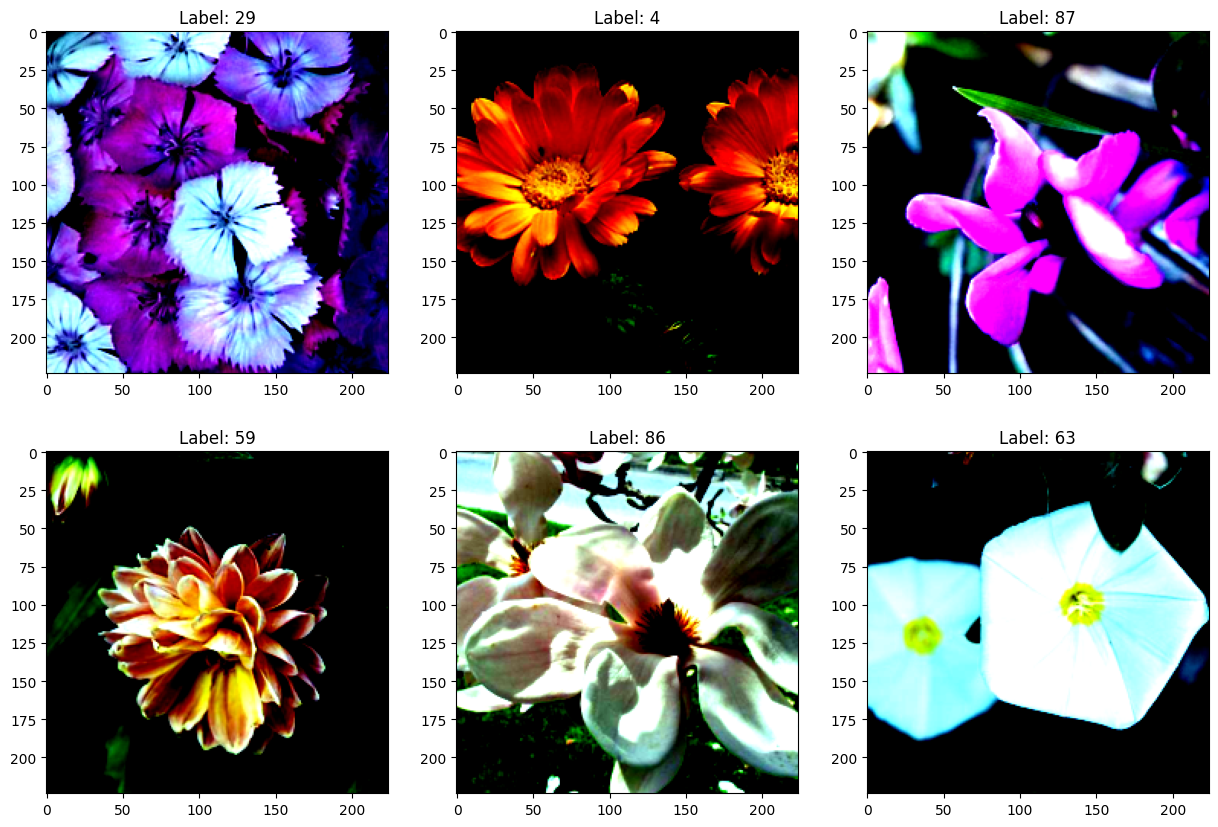

In [5]:
figure = plt.figure(figsize=(15, 10))
cols, rows = 3, 2

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(new_train_data), size=(1,)).item()
    img, label = new_train_data[sample_idx]
    img = img.permute(1, 2, 0)
    ax = figure.add_subplot(rows, cols, i)
    ax.set_title(f'Label: {label}')
    ax.axis("on")
    ax.imshow(img.squeeze(), cmap="Accent")
plt.show()

# Creating Neural Network

In [6]:
class CNN(nn.Module):

  def __init__(self):
     super().__init__()

     self.conv1 = nn.Conv2d(3, 32 ,3 , 1)
     self.relu1 = nn.ReLU()
     self.pool1 = nn.MaxPool2d(3)

     self.conv2 = nn.Conv2d(32, 64 ,3 , 1) #Increase the input layers to 32 as they were outputs of layer 1
     self.relu2 = nn.ReLU()
     self.pool2 = nn.MaxPool2d(3)

     self.conv3 = nn.Conv2d(64, 128 ,3 , 1)
     self.relu3 = nn.ReLU()
     self.pool3 = nn.MaxPool2d(3)

     self.fc1 = nn.Linear(128 * 7 * 7, 1024)
     self.fc2 = nn.Linear(1024, 512)
     self.fc3 = nn.Linear(512, 102) #102 as there is 102 output classes

  def forward(self, x):
     x = F.relu(self.conv1(x)) #Pass through the first layer down to the 3rd
     x = self.pool1(x)

     x = F.relu(self.conv2(x))
     x = self.pool2(x)

     x = F.relu(self.conv3(x))
     x = self.pool3(x)

     x = torch.flatten(x, 1)

     x = F.relu(self.fc1(x)) #Once passed through apply activation of the fully connected
     x = F.relu(self.fc2(x))
     x = self.fc3(x)

     return x

cnn = CNN()

In [7]:
optimizer = optim.ASGD(cnn.parameters(), lr=0.001)

In [8]:
criterion = nn.CrossEntropyLoss()